# Life-Cycle Labor Supply of Couples

Solves and simulates a $T$-period labor supply model with two-earner couples. <br>
**Motivated** by the study “Are Marriage-Related Taxes and Social Security Benefits Holding Back Female Labor Supply?” by Borella et al. (forthcoming). <br>
**Goal** is to replicate effects of individual vs. joint taxation.

For simplicity, couples cannot divorce nor save.

The **Bellman equation** and the recursive formulation of our simple model is 
$$
\begin{align*}
V_{t}(K_{1,t},K_{2,t}) & =\max_{h_{1,t},h_{2,t}}U(c_{t},h_{1,t},h_{2,t})+\beta V_{t+1}(K_{1,t+1},K_{2,t+1})\\
c_{t} & =\sum_{j=1}^{2}w_{j,t}h_{j,t}-T(w_{1,t}h_{1,t},w_{2,t}h_{2,t})\\
\log w_{j,t} & =\alpha_{j,0}+\alpha_{j,1}K_{j,t},\;j\in\{1,2\}\\
K_{j,t+1} & =(1-\delta)K_{j,t}+h_{j,t},\;j\in\{1,2\}
\end{align*}
$$

**Preferences** are sum of individuals
$$
U(c_{t},h_{1,t},h_{2,t})=2\frac{(c_{t}/2)^{1+\eta}}{1+\eta}-\rho_{1}\frac{h_{1,t}^{1+\gamma}}{1+\gamma}-\rho_{2}\frac{h_{2,t}^{1+\gamma}}{1+\gamma}
$$





**Taxes** are on the household level
$$
T(Y_{1},Y_{2})=(1-\lambda(Y_{1}+Y_{2})^{-\tau})\cdot(Y_{1}+Y_{2})
$$

**Terminal period:** There are no bequests such that
$$
V_{T}(K_{1,T},K_{2,T})  =\max_{h_{1,T},h_{2,T}}U(c_{T},h_{1,T},h_{2,T})
$$

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numba as nb

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from scipy.optimize import root_scalar

import pandas as pd


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Question 1

In [60]:
from DynHouseholdLaborModel import DynHouseholdLaborModelClass
model = DynHouseholdLaborModelClass()

par = model.par
sol = model.sol
sim = model.sim

model1 = model.copy(par={'weight_u': True})
model2 = model.copy(par={'weight_u': False})
model3 = model.copy(par={'weight_u': True, 'mu': 0.2})

In [61]:
model.solve()

In [62]:
model1.solve()
model2.solve()
model3.solve()

In [63]:
model1.sim.k1_init = 2.0*np.ones(par.simN)
model1.simulate()
model2.sim.k1_init = 2.0*np.ones(par.simN)
model2.simulate()
model3.sim.k1_init = 2.0*np.ones(par.simN)
model3.simulate()

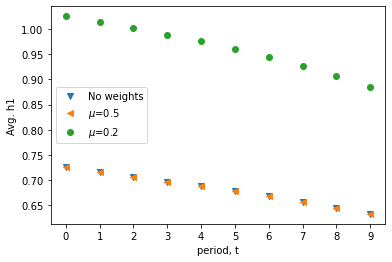

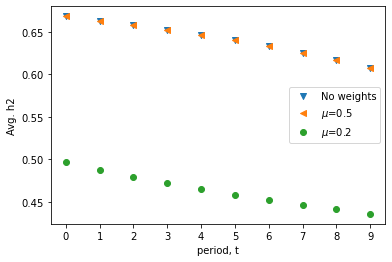

In [64]:
for var in ('h1','h2'):
    fig, ax = plt.subplots()
    ax.scatter(range(par.simT),np.mean(getattr(model2.sim,var),axis=0),label='No weights', marker = 'v')
    ax.scatter(range(par.simT),np.mean(getattr(model1.sim,var),axis=0),label='$\mu$=0.5', marker = '<')
    ax.scatter(range(par.simT),np.mean(getattr(model3.sim,var),axis=0),label='$\mu$=0.2')
    ax.set(xlabel='period, t',ylabel=f'Avg. {var}',xticks=range(par.simT));
    ax.legend();

# Question 3

Policy Reform: move to individual taxation


This means that the household budget is now
$$
c_{t}  =\sum_{j=1}^{2}w_{j,t}h_{j,t}-T(w_{1,t}h_{1,t})-T(w_{2,t}h_{2,t})\\
$$

I implement this via the switch `par.joint_tax=False`.

In [7]:
# Initiate two models with the two different tax regimes
model3 = model.copy(par={'weight_u': False,'joint_tax': True})
model4 = model.copy(par={'weight_u': False,'joint_tax': False})

In [8]:
# Solve and simulate model. Initiate 
model3.solve()
model3.sim.k1_init = 2.0*np.ones(par.simN)
model3.simulate()

In [9]:
# Solve and simulate model with 1 pct. increase in male wage
model3_1 = model3.copy()
model3_1.par.wage_const_1 = np.log(np.exp(par.wage_const_1) * 1.01) # 1% increase in wage
model3_1.solve()
model3_1.sim.k1_init = 2.0*np.ones(par.simN)
model3_1.simulate()

In [10]:
model4.solve()
model4.sim.k1_init = 2.0*np.ones(par.simN)
model4.simulate()

In [11]:
model4_1 = model3.copy()
model4_1.par.wage_const_1 = np.log(np.exp(par.wage_const_1) * 1.01) # 1% increase in wage
model4_1.solve()
model4_1.sim.k1_init = 2.0*np.ones(par.simN)
model4_1.simulate()

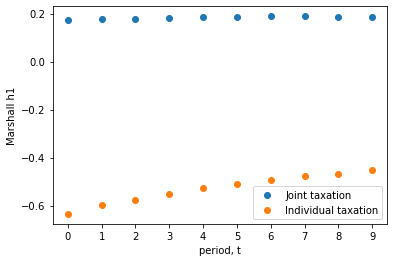

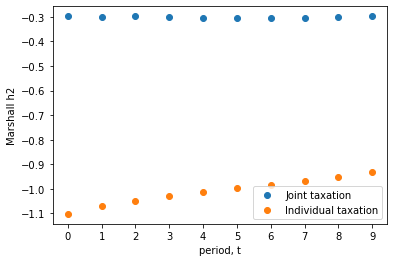

In [12]:
# Elasticities
for var in ('h1','h2'):
    fig, ax = plt.subplots()
    base3 = np.mean(getattr(model3.sim,var),axis=0)
    new3 = np.mean(getattr(model3_1.sim,var),axis=0)
    ela3 = (new3 - base3)/base3*100
    base4 = np.mean(getattr(model4.sim,var),axis=0)
    new4 = np.mean(getattr(model4_1.sim,var),axis=0)
    ela4 = (new4 - base4)/base4*100
    ax.scatter(range(par.simT),ela3,label='Joint taxation')
    ax.scatter(range(par.simT),ela4,label='Individual taxation')
    ax.set(xlabel='period, t',ylabel=f'Marshall {var}',xticks=range(par.simT));
    ax.legend();

Under join taxation, the substitution effect is dominating male labor supply. He can get more out of working when his wage increases and he therefore increases his labor supply. For his wife, the income effect is dominating. Her husband now earns more and she reduces her labor supply.

Under individual taxatiom, the income effect is dominating both male and female labor supply. The effect is stronger for women under individual taxation than under joint taxation - that is; she reduces her labor supply more in this model. This can be do to the fact that she does not face increasing marginal taxes following her husbands wage increase when taxes are individual. Hence, when taxes are joint, the women's marginal tax increases when her husband's wage increases. This means that her wage brings home less net income. Whereas under an individual tax scheme, her marginal income is not reduces, which allows her to work even less. 

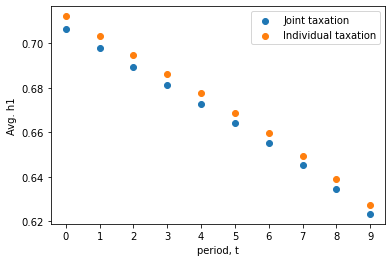

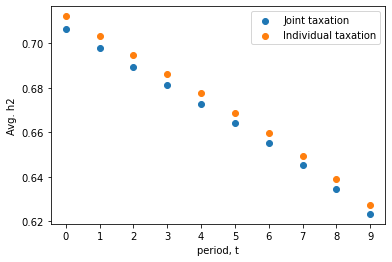

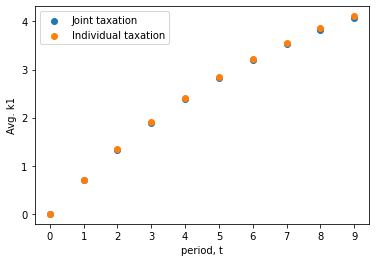

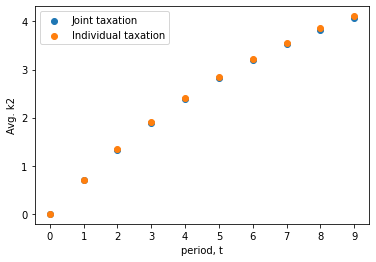

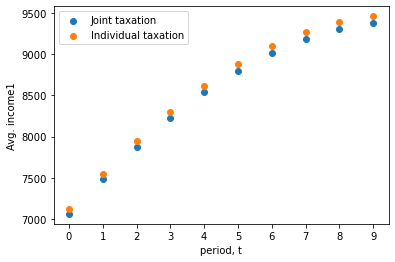

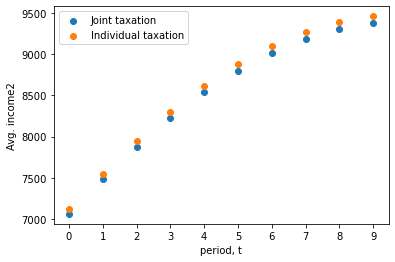

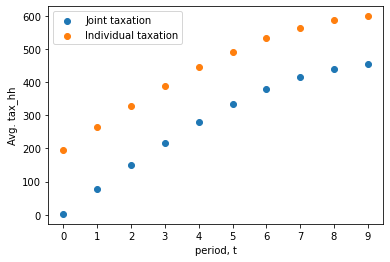

In [13]:
# plot behavior 
for var in ('h1','h2','k1','k2','income1','income2','tax_hh'):
    fig, ax = plt.subplots()
    ax.scatter(range(par.simT),np.mean(getattr(model3.sim,var),axis=0),label='Joint taxation')
    ax.scatter(range(par.simT),np.mean(getattr(model4.sim,var),axis=0),label='Individual taxation')
    ax.set(xlabel='period, t',ylabel=f'Avg. {var}',xticks=range(par.simT));
    ax.legend();

Both men and women work more under an individual tax regime than under a joint one. 

They accumulate a bit more capital over the life cycle. 

They both have higher incomes and their joint tax payments are significantly higher. 

# Question 4
The government budget

In [52]:
# create tax list in each of the two models. 
tax_list = [getattr(model3.sim,'tax_hh'), getattr(model4.sim,'tax_hh')]

[array([[  2.69035101,  78.11252918, 150.33228463, ..., 414.39985842,
         439.72394569, 454.1696517 ],
        [  2.69035101,  78.11252918, 150.33228463, ..., 414.39985842,
         439.72394569, 454.1696517 ],
        [  2.69035101,  78.11252918, 150.33228463, ..., 414.39985842,
         439.72394569, 454.1696517 ],
        ...,
        [  2.69035101,  78.11252918, 150.33228463, ..., 414.39985842,
         439.72394569, 454.1696517 ],
        [  2.69035101,  78.11252918, 150.33228463, ..., 414.39985842,
         439.72394569, 454.1696517 ],
        [  2.69035101,  78.11252918, 150.33228463, ..., 414.39985842,
         439.72394569, 454.1696517 ]]),
 array([[195.44019878, 263.66024419, 328.6605322 , ..., 563.51667494,
         585.8877867 , 598.53270072],
        [195.44019878, 263.66024419, 328.6605322 , ..., 563.51667494,
         585.8877867 , 598.53270072],
        [195.44019878, 263.66024419, 328.6605322 , ..., 563.51667494,
         585.8877867 , 598.53270072],
        ...,


In [51]:
x = np.sum(model3.sim.tax_hh)
print(x)

2749258.0770472083


In [25]:
# Homogenous agents (I can just multiply with a 1.000)
tax_list_joint = (tax_list[0][0])*model3.par.simN # 0: joint taxation, 0: first  (individuals are homogenous and have same tax payments --> I can multiply with number of individuals)
tax_list_indiv = (tax_list[1][0])*model4.par.simN # 1: individual taxation, 0: first observation (individuals are homogenous and have same tax payments --> I can multiply with number of individuals)
total_tax_joint = sum(tax_list_joint) # sum over all periods 
total_tax_indiv = sum(tax_list_indiv) # sum over all periods
diff_y = tax_list_indiv - tax_list_joint # diff in each period
diff_t = total_tax_indiv - total_tax_joint # total diff

In [46]:
tax_list_joint = (tax_list[0][0])*model3.par.simN 
tax_list_joint

array([  2843.79351222,  78130.6253578 , 150355.08261124, 217939.66869361,
       279689.51573406, 333272.26799538, 379002.16853826, 414414.51388952,
       439733.91558328, 454179.12997286])

In [28]:
# create dataframe for government revenue in the two regimes
df = pd.DataFrame({'tax_list_joint': tax_list_joint, 'tax_list_indiv': tax_list_indiv})
df = df.div(100)
df['govt_rev_ratio'] = df['tax_list_joint'] / df['tax_list_indiv']
print(df)

   tax_list_joint  tax_list_indiv  govt_rev_ratio
0       26.903510     1954.401988        0.013766
1      781.125292     2636.602442        0.296262
2     1503.322846     3286.605322        0.457409
3     2179.136029     3891.337539        0.559997
4     2796.769961     4441.419507        0.629702
5     3332.511089     4917.459438        0.677690
6     3789.877485     5322.252146        0.712082
7     4143.998584     5635.166749        0.735382
8     4397.239457     5858.877867        0.750526
9     4541.696517     5985.327007        0.758805


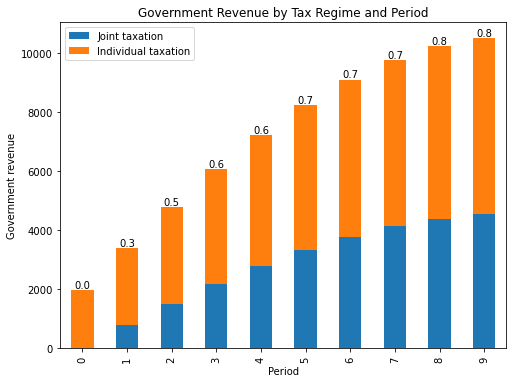

In [29]:
# Create a stacked bar chart
ax = df.plot(kind='bar', stacked=True, figsize=(8,6))

# Add labels and title
ax.set_xlabel('Period')
ax.set_ylabel('Government revenue')
ax.set_title('Government Revenue by Tax Regime and Period')

# Add legends
ax.legend(['Joint taxation', 'Individual taxation'])

# Add the difference values as annotations above the bars
for i, v in enumerate(df['govt_rev_ratio']):
    ax.annotate("{:.1f}".format(v), xy=(i, df.sum(axis=1)[i]), ha='center', va='bottom')

# Show the plot
plt.show()

# Question 5
Determine tax_scale_i that provides the same government budget in joint as in individual taxation

In [30]:
# create tax dictory with tax revenue in each tax regime for different values of tax_scale_i
tax_scale_i_vals = np.linspace(1.76, 1.78, 20)

govt_rev_diff_vals = np.zeros((len(tax_scale_i_vals), par.T))

tax_dict = {}

model5 = model.copy(par={'joint_tax': True})
model5.solve()
model5.sim.k1_init = 2.0*np.ones(par.simN)
model5.simulate()

for t_i, tax_scale_i in enumerate(tax_scale_i_vals):
    model6 = model.copy(par={'joint_tax': False,'tax_scale_i': tax_scale_i})
    model6.solve()
    model6.sim.k1_init = 2.0*np.ones(par.simN)
    model6.simulate()

    tax_dict[tax_scale_i] = [getattr(model5.sim,'tax_hh'), getattr(model6.sim,'tax_hh')]

In [37]:
# Initialize dictionaries to store tax information
tax_list_joint = {}
tax_list_indiv = {}
total_tax_joint = {}
total_tax_indiv = {}
diff_y = {}
diff_t = {}

# Loop through each tax scale in the tax_dict
for tax_scale_i in tax_dict.keys():
    tax_list = tax_dict[tax_scale_i]

    tax_list_joint[tax_scale_i] = (tax_list[0][0])*model5.par.simN
    tax_list_indiv[tax_scale_i]  = (tax_list[1][0])*model6.par.simN
    total_tax_joint[tax_scale_i]  = sum(tax_list_joint[tax_scale_i]) / 1000
    total_tax_indiv[tax_scale_i]  = sum(tax_list_indiv[tax_scale_i]) / 1000 
    diff_y[tax_scale_i]  = tax_list_indiv[tax_scale_i] - tax_list_joint[tax_scale_i]
    diff_t[tax_scale_i]  = total_tax_indiv[tax_scale_i] - total_tax_joint[tax_scale_i]

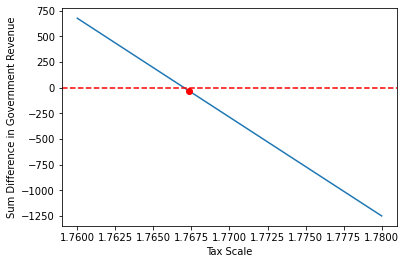

In [38]:
# Plot the mean difference in government revenue for each tax scale
plt.plot(list(diff_t.keys()), list(diff_t.values()))

# Add a red line at y=0
plt.axhline(y=0, color='r', linestyle='--')

# Get the tax scale with the smallest absolute difference in government revenue
best_tax_scale = min(diff_t, key=lambda k: abs(diff_t[k]))

# Get the index of the period with the closest difference to 0
keys_list = list(diff_t.keys())
min_diff_idx = keys_list.index(best_tax_scale)

# Add a red dot at the corresponding point in the plot
plt.plot(best_tax_scale, diff_t[best_tax_scale], 'ro')
        
# Set the x-axis label
plt.xlabel("Tax Scale")

# Set the y-axis label
plt.ylabel("Sum Difference in Government Revenue")

# Show the plot
plt.show()

In [39]:
model7 = model.copy(par={'joint_tax': True})
model7.solve()
model7.sim.k1_init = 2.0*np.ones(par.simN)
model7.simulate()
tax7 = getattr(model7.sim,'tax_hh')
govt_revenue_joint = sum(tax7)
total_govt_revenue_joint = np.sum(govt_revenue_joint)

In [40]:
govt_revenue_joint

array([  2843.79351222,  78130.6253578 , 150355.08261123, 217939.66869361,
       279689.51573406, 333272.26799538, 379002.16853826, 414414.51388953,
       439733.91558329, 454179.12997287])

In [ ]:
def objective(tax_scale_i):

    par.tax_scale_i = np.array([1.75])
    model8 = model.copy(par={'joint_tax': False,'tax_scale_i': tax_scale_i})
    model8.solve()
    model8.sim.k1_init = 2.0*np.ones(par.simN)
    model8.simulate()
    tax8 = getattr(model8.sim,'tax_hh')

    govt_revenue_indiv = sum(tax8)
    total_govt_revenue_indiv = np.sum(govt_revenue_indiv)

    diff = total_govt_revenue_indiv - total_govt_revenue_joint
    print(f"Function value at {tax_scale_i}: {diff}")
    return diff

lower_bound = 1.75
upper_bound = 1.77

print(f"Lower bound: {lower_bound}")
print(f"Upper bound: {upper_bound}")

root_scalar(objective, bracket=[lower_bound, upper_bound], method='brentq')

# Question 6

In [54]:
model9 = model.copy(par={'joint_tax': False, 'tax_scale_i': 1.7670139147700161,'q_6': True})
model9.solve()
model9.sim.k1_init = 8.0*np.ones(par.simN)
model9.sim.k2_init = 8.0*np.ones(par.simN)
model9.simulate()
x1 = -model9.sol.V[0,8,8]
print(x1.shape)
print(x1)

()
0.19461051476196242


In [55]:
model10 = model.copy(par={'joint_tax': False, 'tax_scale_i': 1.7670139147700161, 'q_6': True})
model10.solve()
model10.simulate()
y1 = -model10.sol.V[0,0,0]
print(y1.shape)
print(y1)

()
0.23321036200109652


In [56]:
model11 = model.copy(par={'joint_tax': True,'q_6': True})
model11.solve()
model11.sim.k1_init = 8.0*np.ones(par.simN)
model11.sim.k2_init = 8.0*np.ones(par.simN)
model11.simulate()
x2 = -model11.sol.V[0,8,8]
print(x2.shape)
print(x2)

()
0.1953368859511646


In [57]:
model12 = model.copy(par={'joint_tax': True,'q_6': True})
model12.solve()
model12.simulate()
y2 = -model12.sol.V[0,0,0]
print(y2.shape)
print(y2)

()
0.2332319353969373


In [58]:
high_diff = x2 - x1
print(high_diff)
low_diff = y2 - y1
print(low_diff)

0.0007263711892021851
2.157339584077378e-05


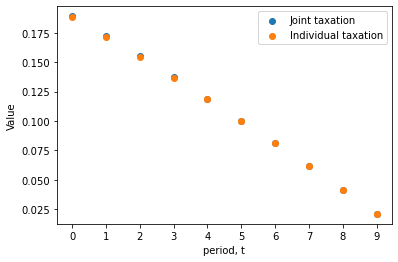

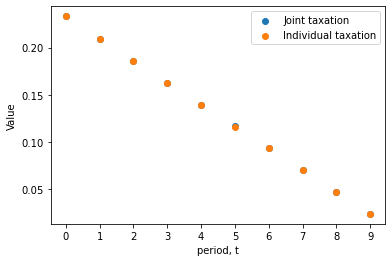

In [59]:
# High human capital 
fig, ax = plt.subplots()
ax.scatter(range(par.simT),-np.mean(getattr(model11.sim,'V'),axis=0),label='Joint taxation')
ax.scatter(range(par.simT),-np.mean(getattr(model9.sim,'V'),axis=0),label='Individual taxation')
ax.set(xlabel='period, t',ylabel=f'Value',xticks=range(par.simT));
ax.legend();

# Low human capital 
fig, ax = plt.subplots()
ax.scatter(range(par.simT),-np.mean(getattr(model12.sim,'V'),axis=0),label='Joint taxation')
ax.scatter(range(par.simT),-np.mean(getattr(model10.sim,'V'),axis=0),label='Individual taxation')
ax.set(xlabel='period, t',ylabel=f'Value',xticks=range(par.simT));
ax.legend();